In [1]:
!pip install nltk
!pip install spacy

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install pandas
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import RandomizedSearchCV
#from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix,f1_score, precision_score, recall_score

In [4]:
cd /content/drive/MyDrive/My_Experiment/Decision_Tree

/content/drive/MyDrive/My_Experiment/Decision_Tree


In [5]:
!pwd

/content/drive/MyDrive/My_Experiment/Decision_Tree


In [6]:
train_df = pd.read_csv('Hindi_Hasoc2019.tsv',delimiter="\t")
train_df= train_df.dropna(how='all')
train_df = train_df.rename(columns={'text': 'text','task_1': 'labels', })
train = train_df[['text', 'labels']]

In [7]:
#train["labels"].value_counts()

In [8]:
train["tweetid"] = train.index
#train.head(10)

<ipython-input-8-e503e7a30bff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["tweetid"] = train.index


In [9]:
import re

def remove_urls(text):
    # Define the regex pattern for URLs starting with http or https
    url_pattern = re.compile(r'http[s]?://\S+')
    # Substitute the URLs with an empty string
    cleaned_text = url_pattern.sub('', text)
    return cleaned_text.strip()


In [10]:
import re
def remove_emojis_and_smiles(text):
    # Regex pattern to match emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001FAFF"  # Supplemental Symbols and Pictographs
                           u"\U0001FB00-\U0001FBFF"  # Symbols and Pictographs Extended-A
                           u"\U0001FC00-\U0001FFFF"  # reserved
                           u"\U00002702-\U000027B0"  # Dingbats
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    # Remove emojis
    text = emoji_pattern.sub(r'', text)

    # Regex pattern to match common smiley faces
    smiley_pattern = re.compile(r'[:;]-?[)D(]|[)D]-?[:;]')

    # Remove smiley faces
    text = smiley_pattern.sub(r'', text)

    return text

In [11]:
import html
import re

# Regular expression to replace multiple spaces with a single space
re1 = re.compile(r' +')

# Regular expression to remove special symbols except for the ones you want to keep
special_symbols_re = re.compile(r'[@#&<>^*(){}[\]|\\;:"`~!$%^+=?,./]')
from spacy.lang.hi import STOP_WORDS as STOP_WORDS_HI

def textFixup(aText):
    # Replace specific HTML entities and other patterns
    aText = aText.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ').replace('â€™', "'")

    # Remove special symbols
    aText = special_symbols_re.sub(' ', aText)
    aText = [word for word in aText.split() if word not in set(STOP_WORDS_HI) ]
    aText=' '.join(aText)
    # Replace multiple spaces with a single space and unescape HTML entities
    return re1.sub(' ', html.unescape(aText))

In [12]:
import html
def preprocess_aTweet(tweet):
    tweet = tweet.lower()
    tweet = textFixup(tweet)
    return tweet

In [13]:
X_train, X_test, y_train, y_test = train_test_split(train[["text"]],train[["labels"]], test_size=0.25, random_state=0)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [14]:

X_train_processed = X_train['text'].apply(lambda x: remove_urls(x))
X_test_processed = X_test['text'].apply(lambda x: remove_urls(x))

In [15]:
X_train_processed = X_train['text'].apply(lambda x: preprocess_aTweet(x))
X_test_processed = X_test['text'].apply(lambda x: preprocess_aTweet(x))

In [16]:
print(X_test.iloc[2])

text    Akali Dal in BJP alliance is husband & wife co...
Name: 2, dtype: object


In [17]:
vec=TfidfVectorizer(tokenizer=word_tokenize,token_pattern=None,ngram_range=(1,1))
X_train_vectorized=vec.fit_transform(X_train_processed)
X_test_vectorized=vec.transform(X_test_processed)

In [18]:
label_encoder=LabelEncoder()
y_train_encoded=label_encoder.fit_transform(y_train)
y_test_encoded=label_encoder.transform(y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [19]:
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

# Paths to the font files
hindi_font_path = 'Lohit-Devanagari.ttf'
english_font_path = 'Arial-Regular.ttf'

# Add the fonts to Matplotlib
fm.fontManager.addfont(hindi_font_path)
fm.fontManager.addfont(english_font_path)

# Load the fonts using FontProperties
hindi_font_prop = fm.FontProperties(fname=hindi_font_path)
english_font_prop = fm.FontProperties(fname=english_font_path)

# Set the default font family to use both fonts
plt.rcParams['font.family'] = [english_font_prop.get_name(), hindi_font_prop.get_name()]

# Print the names of the fonts to ensure they're loaded correctly
print(f"Loaded English font: {english_font_prop.get_name()}")
print(f"Loaded Hindi font: {hindi_font_prop.get_name()}")

Loaded English font: Arial
Loaded Hindi font: Lohit Devanagari


BERTopic Topic Modelling

In [20]:
tweets=train["text"]

In [21]:
def remove_https_urls(text):
    # Define the regex pattern for HTTP and HTTPS URLs
    url_pattern = r'http[s]?://[^\s]+'

    # Use re.sub() to replace the URLs with an empty string
    cleaned_text = re.sub(url_pattern, '', text)

    return cleaned_text

In [22]:
tweets = [remove_https_urls(tweet) for tweet in tweets]

In [23]:
preprocessed_tweets = [textFixup(tweet) for tweet in tweets]

In [24]:
pip install BERTopic

In [25]:
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [26]:
from bertopic import BERTopic

In [27]:
embedding_model = SentenceTransformer("sentence-transformers/LaBSE")


from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired, PartOfSpeech, MaximalMarginalRelevance

main_representation_model = KeyBERTInspired()

representation_model = {
   "Main": main_representation_model
}


vectorizer_model = TfidfVectorizer(tokenizer=word_tokenize,token_pattern=None,ngram_range=(1,1))


umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.1, metric='cosine',random_state=42)


hdbscan_model = HDBSCAN(min_cluster_size=5, min_samples=1)

topic_model = BERTopic(nr_topics=15,embedding_model=embedding_model, umap_model=umap_model, hdbscan_model=hdbscan_model,verbose=True,language="multilingual",vectorizer_model = vectorizer_model,
                      representation_model = representation_model)


topics, probabilities = topic_model.fit_transform(preprocessed_tweets)



modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.22k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

2024-07-31 14:08:48,797 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/146 [00:00<?, ?it/s]

2024-07-31 14:09:05,862 - BERTopic - Embedding - Completed ✓
2024-07-31 14:09:05,864 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-31 14:09:39,519 - BERTopic - Dimensionality - Completed ✓
2024-07-31 14:09:39,521 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-31 14:09:39,746 - BERTopic - Cluster - Completed ✓
2024-07-31 14:09:39,748 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-07-31 14:09:55,073 - BERTopic - Representation - Completed ✓
2024-07-31 14:09:55,075 - BERTopic - Topic reduction - Reducing number of topics
2024-07-31 14:09:56,700 - BERTopic - Topic reduction - Reduced number of topics from 286 to 15


In [28]:
topic_model.visualize_barchart(top_n_topics = 16, n_words = 10)

In [29]:
len(topics)

4665

In [30]:
tweets_dict={}
tweets_dict["tweetid"]=[]
tweets_dict["text"]=[]
tweets_dict["topic"]=[]
tweets_dict["labels"]=[]
for i, (tweet, topic) in enumerate(zip(tweets, topics)):
    #print(f"Tweet {i+1}: {tweet}")
    #print(f"Interesting Topic: {topic}")
    tweets_dict["tweetid"].append(i)
    tweets_dict["text"].append(tweet)
    tweets_dict["topic"].append(topic)
    tweet_label=train.loc[train['tweetid'] == i, 'labels'].iloc[0]
    tweets_dict["labels"].append(tweet_label)

tweets_df=pd.DataFrame.from_dict(tweets_dict)
tweets_df.head(10)


,tweetid,text,topic,labels
0,0,"बांग्लादेश की शानदार वापसी, भारत को 314 रन पर ...",-1,NOT
1,1,सब रंडी नाच देखने मे व्यस्त जैसे ही कोई #शांती...,2,HOF
2,2,तुम जैसे हरामियों के लिए बस जूतों की कमी है शु...,3,HOF
3,3,"बीजेपी MLA आकाश विजयवर्गीय जेल से रिहा, जमानत ...",0,NOT
4,4,चमकी बुखार: विधानसभा परिसर में आरजेडी का प्रदर...,0,NOT
5,5,मुंबई में बारिश से लोगों को काफी समस्या हो रही है,4,NOT
6,6,Ahmed's dad:-- beta aaj teri mammy kyu nahi ba...,0,NOT
7,7,"5 लाख मुसलमान उर्स में, अजमेर की दरगाह पर आते ...",-1,NOT
8,8,"Do mahashaktiyan mili hain, charo taraf khusi ...",5,NOT
9,9,Chants of 'Jai Sri Ram' as Owaisi takes oath: ...,0,NOT


In [31]:
topic_model.get_topic_info(0)

,Topic,Count,Name,Representation,Representative_Docs
0,0,2061,0_बीजेपी_भाजपा_दिल्ली_मोदी,"[बीजेपी, भाजपा, दिल्ली, मोदी, सरकार, पत्रकार, ...",[MehboobaMufti रंग असर इतना हुनर मायने रखे टीम...


In [32]:
freq=topic_model.get_topic_info()
len(freq)

15

In [33]:
topic_model.get_topic_info(-1)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1365,-1_मोदी_मीडिया_मुस्लिम_मुसलमान,"[मोदी, मीडिया, मुस्लिम, मुसलमान, इस्लाम, बीजेप...",[शहीदों नाम “सियासत” तुम “संसद” 303 गये अब इतन...


In [34]:
l=len(freq)
topic_info_list=[]
for i in range(l):
  topic_info=topic_model.get_topic_info(i)
  topic_info_list.append(topic_info)

topics_info_df=pd.concat(topic_info_list,ignore_index=True)

In [35]:
topics_info_df

,Topic,Count,Name,Representation,Representative_Docs
0,0,2061,0_बीजेपी_भाजपा_दिल्ली_मोदी,"[बीजेपी, भाजपा, दिल्ली, मोदी, सरकार, पत्रकार, ...",[MehboobaMufti रंग असर इतना हुनर मायने रखे टीम...
1,1,309,1_बज़्म_मासिक_प्रतियोगिता_हिन्दी_शब्द_हिंदी_शब...,"[बज़्म_मासिक_प्रतियोगिता, हिन्दी_शब्द, हिंदी_श...",[पायलों संगीत तेरी मेरी रूह क्यों सहलाता तुझको...
2,2,301,2_720p_चुदाई_देसी_हिंदी,"[720p, चुदाई, देसी, हिंदी, हिन्दी, इंडियन, कुत...",[देसी चुदाई हिंदी - होटल घोड़ी स्टाइल बड़े लुं...
3,3,250,3_तेरी_तुम्हारा_तुम्हारी_तेरे,"[तेरी, तुम्हारा, तुम्हारी, तेरे, तू, तुम, तेरा...",[सुअर औलाद गटर किड़े साला हलाला पैदाइश तुझे ते...
4,4,115,4_मुंबई_mumbairainsliveupdates_mumbai_mumbaira...,"[मुंबई, mumbairainsliveupdates, mumbai, mumbai...",[Mumbai मानसून दस्तक दे दी है। आज सुबह इलाकों ...
5,5,114,5_aapke_aapka_bhai_aap,"[aapke, aapka, bhai, aap, bhi, yahi, kar, chac...",[Is bar to har gye ho Abhi tak Neta ji ki waje...
6,6,52,6_काय_क्या_whoever_मरी,"[काय, क्या, whoever, मरी, गार्ड, है।कैसे, अच्छ...","[काय मस्त गार्ड हाँ मरी रंडि नाभि, Normally wh..."
7,7,31,7_हमें_हिंदू_हराम_हम_हमरे,"[हमें, हिंदू_हराम, हम, हमरे, हमे, है।हम, अल्ला...",[अल्लाह हुक्म बग़ावत सीधे अल्लाह बगावत नमाज़ र...
8,8,20,8_कमाने_paytm_विजेता_खेलें,"[कमाने, paytm, विजेता, खेलें, जीतें, playandwi...",[रहें PlayAndWinOnZee 19 जून विजेता खेलें जीते...
9,9,17,9_कुत्तों_कुत्ते_4-5_हम_कुत्ते,"[कुत्तों, कुत्ते, 4-5, हम_कुत्ते, बच्ची, डर, ब...",['ॐ' छोटी सी बच्ची गली 4-5 कुत्तों देखकर डर गई...


In [36]:
import pandas as pd
df = pd.DataFrame({'Tweet': tweets, 'Interesting topics': topics})
df

,Tweet,Interesting topics
0,"बांग्लादेश की शानदार वापसी, भारत को 314 रन पर ...",-1
1,सब रंडी नाच देखने मे व्यस्त जैसे ही कोई #शांती...,2
2,तुम जैसे हरामियों के लिए बस जूतों की कमी है शु...,3
3,"बीजेपी MLA आकाश विजयवर्गीय जेल से रिहा, जमानत ...",0
4,चमकी बुखार: विधानसभा परिसर में आरजेडी का प्रदर...,0
...,...,...
4660,पाकिस्तान ने हिंदुओं के ख़िलाफ़ बोलने वाले को ...,-1
4661,कोहली है #नेहरू नहीं जो अंग्रेजों के तलवे चाटन...,0
4662,परशुराम? वही जिसने अपनी मां की हत्या की थीं?,0
4663,जिस देश में #कन्हैया_कुमार जैसा पढ़ा लिखा युवा...,0


In [37]:
freq=topic_model.get_topic_info()
len(freq)

15

In [38]:
l=len(freq)
topics_info_dfs={}
for i in range(l):
  topics_info_dfs[f'topic_{i}']=pd.DataFrame(topic_model.get_topic_info(i))

LogisticRegression

In [39]:
from sklearn.linear_model import LogisticRegression

# Load the DataFrame
outliers = tweets_df.loc[tweets_df['topic'] == -1]
df_topic_0 = tweets_df.loc[tweets_df['topic'] == 0]
df_topic_1 = tweets_df.loc[tweets_df['topic'] == 1]
df_topic_2 = tweets_df.loc[tweets_df['topic'] == 2]
df_topic_3 = tweets_df.loc[tweets_df['topic'] == 3]
df_topic_4 = tweets_df.loc[tweets_df['topic'] == 4]



In [40]:
print(len(outliers))

1365


In [41]:
!pip install openpyxl
df = pd.read_excel("/content/drive/MyDrive/My_Experiment/Decision_Tree/InCorrect_Labels2.xlsx",engine='openpyxl')
df=df.dropna()

#df = pd.read_excel("InCorrect_Labels.xlsx")
#df=df.dropna()
df.head(6)

,Tweet ID,Tweet,Label,Roman Hindi,English,Label Change
0,3505,बाॅलिवुड के हिरो/हिरोईन ओर डायरेक्टर को दिखाओ ...,NOT,Bollywood ke hero/heroine aur director ko dikh...,Show this to the Bollywood heroes/heroines and...,HOF
1,4193,"Shamefull for Modi ji BJP, who is using ARMY, ...",NOT,"Shamefull for Modi ji BJP, jo ARMY, Bollywood ...","Shameful for Modi ji and BJP, who are using AR...",HOF
2,2496,कितना easy सवाल भारत क्या पूरे विश्व को पता है...,NOT,Kitna easy sawal Bharat kya poore vishv ko pat...,How easy is the question that India and the wh...,HOF
3,1064,"प्राकृतिक वर्फ भरे पहाड़, ठंड भरी ओस से गीली स...",NOT,"Praakritik varf bhare pahad, thand bhari os se...","Natural snow-covered mountains, cold dew-drenc...",HOF
4,2701,लगता है #गांजे को लेकर आपका निशाना #राहुल_गाँध...,NOT,Lagta hai #ganje ko lekar aapka nishana #Rahul...,It seems your target regarding #weed is aimed ...,HOF
5,2558,अय्यर के #नीच वाले बयान के लिए कांग्रेस जिम्मे...,NOT,Aiyyar ke #neech wale bayaan ke liye Congress ...,Congress is responsible for Aiyar's #low state...,HOF


In [42]:
df['Tweet ID'] = df['Tweet ID'].astype(int)

df.loc[:, "Tweet ID"] = df["Tweet ID"].apply(lambda x: x - 1)
ids_to_check = df["Tweet ID"].values.tolist()
print(ids_to_check)

[3504, 4192, 2495, 1063, 2700, 2557, 2641, 3807, 4654, 4648, 4645, 4644, 4642, 4626, 4621, 4617, 4612, 4611, 4608, 4607, 4601, 4597, 4589, 4587, 4578, 4576, 4575, 4572, 4566, 4565, 4559, 4545, 4543, 4537, 4533, 4532, 4531, 4528, 4527, 4521, 4514, 4510, 4500, 4495, 4486, 4474, 4471, 4463, 4456, 4445, 4432, 4424, 4404, 4402, 4374, 4368, 4374, 4324, 4342, 4329, 4327, 4321, 4316, 4304, 4302, 4293, 4287, 4284, 4280, 4270, 4268, 4263, 4232, 4226, 4222, 4217, 4216, 4214, 4211, 4196, 4194, 4180, 4178, 4168, 4130, 4126, 4124, 4112, 4104, 4101, 4083, 4082, 4065, 4062, 4055, 4049, 4042, 4038, 4024, 4020, 4013, 4012, 4006, 3994, 3990, 3983, 3979, 3966, 3963, 3961, 3957, 3953, 3952, 3939, 3931, 3925, 3915, 3911, 3891, 3889, 3876, 3867, 3852, 3844, 3840, 3830, 3807, 3789, 3765, 3739, 3734, 3730, 3722, 3703, 3666, 3657, 3627, 3620, 3617, 3616, 3608, 3603, 3590, 3570, 3568, 3555, 3551, 3547, 3536, 3520, 3494, 3461, 3436, 3411, 3407, 3403, 3402, 3390, 3388, 3385, 3376, 3375, 3373, 3372, 3371, 3368, 336

In [43]:
print(len(ids_to_check))

320


In [44]:
filtered_df_0 = df_topic_0[df_topic_0['tweetid'].isin(ids_to_check)]
print(filtered_df_0.shape)
filtered_df_0["labels"].value_counts()
#df['newlabels'] = ~filtered_df_0['labels']
filtered_df_0['newlabels'] = np.where(filtered_df_0['labels']== 'HOF', 'NOT', 'HOF')


(143, 4)


In [45]:
X_train, X_test, y_train, y_test = train_test_split(filtered_df_0["text"], filtered_df_0[['labels']])



tfidf_vectorizer1 = TfidfVectorizer()

X_train_tf = tfidf_vectorizer1.fit_transform(X_train)
# transform the test set with vectoriser
X_test_tf = tfidf_vectorizer1.transform(X_test)

label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
y_train_encoded = label_encoder.fit_transform(y_train)

# create logistic regression model
logreg = LogisticRegression(verbose=1, random_state=0, penalty='l2', solver='newton-cg')
# train model on  vectorised training data
model = logreg.fit(X_train_tf, y_train_encoded)
# evaluate model performance on the test set
pred = model.predict(X_test_tf)
metrics.f1_score(y_test_encoded, pred, average='weighted')


0.49811676082862516

In [46]:
filtered_df_1 = df_topic_1[df_topic_1['tweetid'].isin(ids_to_check)]
filtered_df_1.shape

(13, 4)

In [47]:
outlier_df = outliers[outliers['tweetid'].isin(ids_to_check)]
outlier_df.shape

(97, 4)

In [48]:
filtered_df_2 = df_topic_2[df_topic_2['tweetid'].isin(ids_to_check)]
filtered_df_2.shape

(20, 4)

In [49]:
filtered_df_3 = df_topic_3[df_topic_3['tweetid'].isin(ids_to_check)]
filtered_df_3.shape

(20, 4)

In [50]:
filtered_df_4 = df_topic_4[df_topic_4['tweetid'].isin(ids_to_check)]
filtered_df_4.shape

(6, 4)

In [51]:
import numpy as np
filtered_notdf_0=df_topic_0[np.logical_not(df_topic_0["tweetid"].isin(ids_to_check))]
print(filtered_notdf_0.shape)
filtered_notdf_0["labels"].value_counts()

(1918, 4)


,count
labels,
NOT,1036
HOF,882


In [52]:
X_train, X_test, y_train, y_test = train_test_split(filtered_notdf_0["text"], filtered_notdf_0[['labels']])


tfidf_vectorizer1 = TfidfVectorizer()

X_train_tf = tfidf_vectorizer1.fit_transform(X_train)
# transform the test set with vectoriser
X_test_tf = tfidf_vectorizer1.transform(X_test)

label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
y_train_encoded = label_encoder.fit_transform(y_train)

# create logistic regression model
logreg = LogisticRegression(verbose=1, random_state=0, penalty='l2', solver='newton-cg')
# train model on  vectorised training data
model = logreg.fit(X_train_tf, y_train_encoded)
# evaluate model performance on the test set
pred = model.predict(X_test_tf)
metrics.f1_score(y_test_encoded, pred, average='weighted')

0.7402681814944084

In [53]:
incorrectlabels_df = filtered_df_0
correctlabels_df=filtered_notdf_0.sample(n=120, random_state=1)
merged_df=pd.concat([incorrectlabels_df, correctlabels_df], axis=0)


In [54]:
#new_df=new_df.dropna()
merged_df.shape

(263, 5)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(merged_df["text"], merged_df[['labels']])


tfidf_vectorizer1 = TfidfVectorizer()

X_train_tf = tfidf_vectorizer1.fit_transform(X_train)
# transform the test set with vectoriser
X_test_tf = tfidf_vectorizer1.transform(X_test)

label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
y_train_encoded = label_encoder.fit_transform(y_train)

# create logistic regression model
logreg = LogisticRegression(verbose=1, random_state=0, penalty='l2', solver='newton-cg')
# train model on  vectorised training data
model = logreg.fit(X_train_tf, y_train_encoded)
# evaluate model performance on the test set
pred = model.predict(X_test_tf)
metrics.f1_score(y_test_encoded, pred, average='weighted')

0.5781266997860536

In [56]:
#47, 56, 70

In [57]:
incorrectlabels_df.head()

,tweetid,text,topic,labels,newlabels
12,12,डॉ. मुखर्जी ने एक देश में दो विधान दो प्रधान औ...,0,NOT,HOF
100,100,तबरेज के लिए तो तेरे अमनपसंद कौम के अम्मि बेगम...,0,HOF,NOT
470,470,"#AIMIM Chief @asadowaisi says to the Chair, '...",0,HOF,NOT
473,473,केजरीवाल सरकार झारखंड में जिस चोर को पब्लिक ने...,0,HOF,NOT
593,593,"World Cup 2019: निकोलस पूरन बोले, 'भारत के खिल...",0,NOT,HOF


In [58]:
import csv
to_write = [['tweetid', 'tweet', 'label','roman','english','labelchange']]
incorrect_labels_tweetids_0=incorrectlabels_df["tweetid"].values.tolist()
correct_labels_tweetdict=correctlabels_df.to_dict("records")

dictionary_incorrect_labels=df.to_dict("records")
for item in dictionary_incorrect_labels:
    if (item["Tweet ID"]) in incorrect_labels_tweetids_0:
        to_write.append([item["Tweet ID"],item["Tweet"],item["Label"],item["Roman Hindi"],item["English"],True])
for item in correct_labels_tweetdict:
    to_write.append([item["tweetid"],item["text"],item["labels"],"n/a","n/a",False])



file_path = "metadata_HASOC2019_annotations.csv"

with open(file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(to_write)

In [59]:
metadatafeatures_hasoc = pd.read_csv('metadata_HASOC2019_annotations_final.csv')
metadatafeatures_hasoc=metadatafeatures_hasoc.drop('Unnamed: 10', axis=1)
metadatafeatures_hasoc=metadatafeatures_hasoc.drop('Unnamed: 11', axis=1)
metadatafeatures_hasoc=metadatafeatures_hasoc.dropna()
metadatafeatures_hasoc['labelchange'] = metadatafeatures_hasoc['labelchange'].map({True: 1, False: 0})

metadatafeatures_hasoc.head()

,tweetid,tweet,label,roman,english,labelchange,entity,politicalentity,swearwords,targetgroup
0,2495,कितना easy सवाल भारत क्या पूरे विश्व को पता है...,NOT,Kitna easy sawal Bharat kya poore vishv ko pat...,How easy is the question that India and the wh...,1,1.0,1.0,1.0,0.0
1,1063,"प्राकृतिक वर्फ भरे पहाड़, ठंड भरी ओस से गीली स...",NOT,"Praakritik varf bhare pahad, thand bhari os se...","Natural snow-covered mountains, cold dew-drenc...",1,1.0,0.0,0.0,0.0
2,2557,अय्यर के #नीच वाले बयान के लिए कांग्रेस जिम्मे...,NOT,Aiyyar ke #neech wale bayaan ke liye Congress ...,Congress is responsible for Aiyar's #low state...,1,1.0,1.0,0.0,0.0
3,2641,लीजिये मुजराबाजी शुरू हलाला वालीयों का चोर रंड...,NOT,Lijiye mujarabazi shuru halala waliyon ka chor...,Here comes the dance of criminals and those in...,1,0.0,0.0,1.0,1.0
4,3807,देशभक्त मोहम्मद शमी ने तीसरे मैच में भी 5 लिया...,NOT,Deshbhakt Mohammad Shami ne teesre match mein ...,Patriot Mohammad Shami took 5 wickets in the t...,1,1.0,0.0,1.0,0.0


In [60]:
X_features=metadatafeatures_hasoc[["entity", "politicalentity","swearwords","targetgroup"]]
target=metadatafeatures_hasoc["labelchange"]
print(target)
x_train, x_test, y_train, y_test = train_test_split(X_features.values, target, stratify=target, test_size=0.3, random_state=8)
#print(x_train)


0      1
1      1
2      1
3      1
4      1
      ..
130    1
131    1
132    1
133    1
134    1
Name: labelchange, Length: 133, dtype: int64


In [61]:
!pip install pytorch-tabnet

import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score

clf1_nopreproc = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
                      )

# fit the model
clf1_nopreproc.fit(
    x_train,y_train,
    eval_set=[(x_train, y_train), (x_test, y_test)],
    eval_name=['train', 'valid'],
    eval_metric=['balanced_accuracy'],
    max_epochs=1000 , patience=50,
    batch_size=32, virtual_batch_size=32,
    num_workers=0,
    weights=1,
    drop_last=False
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.4 MB/s eta 0:00:00
epoch 0  | loss: 0.00071 | train_balanced_accuracy: 1.0     | valid_balanced_accuracy: 1.0     |  0:00:01s
epoch 1  | loss: 0.00076 | train_balanced_accuracy: 1.0     | valid_balanced_accuracy: 1.0     |  0:00:02s
epoch 2  | loss: 0.00058 | train_balanced_accuracy: 1.0     | valid_balanced_accuracy: 1.0     |  0:00:02s
epoch 3  | loss: 0.00061 | train_balanced_accuracy: 1.0     | valid_balanced_accuracy: 1.0     |  0:00:02s
epoch 4  | loss: 0.00046 | train_balanced_accuracy: 1.0     | valid_balanced_accuracy: 1.0     |  0:00:02s
epoch 5  | loss: 0.00043 | train_balanced_accuracy: 1.0     | valid_balanced_accuracy: 1.0     |  0:00:02s
epoch 6  | loss: 0.00041 | train_balanced_accuracy: 1.0     | valid_balanced_accuracy: 1.0     |  0:00:03s
epoch 7  | loss: 0.00031 | train_balanced_accuracy: 1.0     | valid_balanced_accuracy: 1.0     |  0:00:03s
epoch 8  | loss: 0.00038 | train_balanced_accuracy: 1.0     | vali

BEST ACCURACY SCORE ON VALIDATION SET : 1.0
BEST ACCURACY SCORE ON TEST SET : 1.0


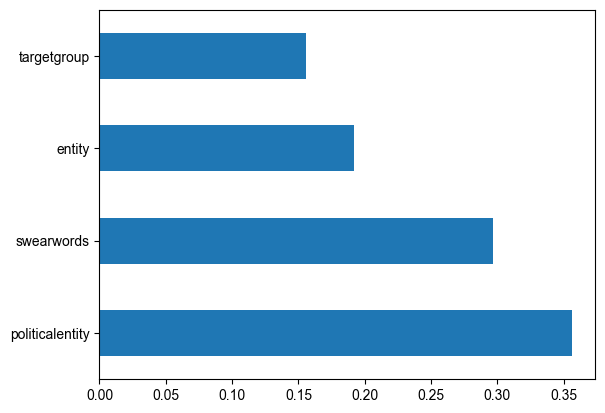

In [62]:


# find and plot feature importance
y_pred = clf1_nopreproc.predict(x_test)
clf1_nopreproc.feature_importances_
feat_importances = pd.Series(clf1_nopreproc.feature_importances_, index=X_features.columns)
feat_importances.nlargest(20).plot(kind='barh')


# determine best accuracy for test set
preds = clf1_nopreproc.predict(x_test)
test_acc = accuracy_score(preds, y_test)

# determine best accuracy for validation set
preds_valid = clf1_nopreproc.predict(x_test)
valid_acc = accuracy_score(preds_valid, y_test)

print(f"BEST ACCURACY SCORE ON VALIDATION SET : {valid_acc}")
print(f"BEST ACCURACY SCORE ON TEST SET : {test_acc}")